# Insurance Prediction Challenge

## Context

https://zindi.africa/competitions/insurance-prediction-challenge

## Importation des modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
# encoding
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay

import random
from datetime import datetime as dt

from joblib import Parallel, delayed
import joblib

In [2]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

## Chargement des jeux de données

In [3]:
DATA_PATH = 'data/'
train = pd.read_csv(DATA_PATH + 'train_data.csv')
test = pd.read_csv(DATA_PATH + 'test_data.csv')
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv')
variable_description = pd.read_csv(DATA_PATH + 'VariableDescription.csv')

In [4]:
train.head(3)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0


In [5]:
test.head(3)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310


## EDA

Train and test set ratio

In [13]:
# proportion de l'ensemble de test par rapport à l'ensemble d'apprentissage 
test.shape[0] * 100 / (train.shape[0] + test.shape[0])

30.00293283800958

Features description

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         3069 non-null   object 
 1   YearOfObservation   3069 non-null   int64  
 2   Insured_Period      3069 non-null   float64
 3   Residential         3069 non-null   int64  
 4   Building_Painted    3069 non-null   object 
 5   Building_Fenced     3069 non-null   object 
 6   Garden              3065 non-null   object 
 7   Settlement          3069 non-null   object 
 8   Building Dimension  3056 non-null   float64
 9   Building_Type       3069 non-null   int64  
 10  Date_of_Occupancy   2341 non-null   float64
 11  NumberOfWindows     3069 non-null   object 
 12  Geo_Code            3056 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 311.8+ KB


In [19]:
target = 'Claim'
users_id = 'Customer Id'

In [20]:
for colonne in list(train.columns):
    print(colonne)
    print(train[colonne].value_counts(), '\n')

Customer Id
H14663    1
H19182    1
H1571     1
H15027    1
H15026    1
         ..
H5025     1
H19098    1
H16571    1
H16570    1
H7470     1
Name: Customer Id, Length: 7160, dtype: int64 

YearOfObservation
2012    1858
2013    1811
2014    1373
2015    1075
2016    1043
Name: YearOfObservation, dtype: int64 

Insured_Period
1.000000    5325
0.997268     547
0.000000     165
0.747945      60
0.495890      49
            ... 
0.435616       1
0.308743       1
0.437158       1
0.578082       1
0.030137       1
Name: Insured_Period, Length: 401, dtype: int64 

Residential
0    4973
1    2187
Name: Residential, dtype: int64 

Building_Painted
V    5382
N    1778
Name: Building_Painted, dtype: int64 

Building_Fenced
N    3608
V    3552
Name: Building_Fenced, dtype: int64 

Garden
O    3602
V    3551
Name: Garden, dtype: int64 

Settlement
R    3610
U    3550
Name: Settlement, dtype: int64 

Building Dimension
400.0     150
500.0     120
300.0     118
450.0     117
600.0     114
        

Analyse des variables qualitatives

In [14]:
train.select_dtypes(include='object').describe()

,Customer Id,Building_Painted,Building_Fenced,Garden,Settlement,NumberOfWindows,Geo_Code
count,7160,7160,7160,7153,7160,7160,7058
unique,7160,2,2,2,2,11,1307
top,H14663,V,N,O,R,.,6088
freq,1,5382,3608,3602,3610,3551,143


Analyse des variables quantitatives

In [40]:
train.select_dtypes(include='number').describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


> - La colonne `Customer Id` ne contient que des éléments uniques. Elle ne sera pas utile à notre apprentissage. <br>
> - La colonne `NumberOfWindows` contient des chiffres de 1 à 9 et deux valeurs spéciales : un point (.) et une description mathématique (>=10). Ce qui a fait de cette colonne une variable _object_. Pour un apprentissage correct, nous transformerons ces deux valeurs spéciales en chiffres, soit 0 et 10 respectivement. <br>
> - La colonne `Geo_Code` a l'air de ne contenir que des nombres mais il s'avère qu'elle est de type _object_.

Analyse des données manquantes

In [21]:
train.isnull().sum() / train.shape[0] * 100

Customer Id           0.000000
YearOfObservation     0.000000
Insured_Period        0.000000
Residential           0.000000
Building_Painted      0.000000
Building_Fenced       0.000000
Garden                0.097765
Settlement            0.000000
Building Dimension    1.480447
Building_Type         0.000000
Date_of_Occupancy     7.094972
NumberOfWindows       0.000000
Geo_Code              1.424581
Claim                 0.000000
dtype: float64

Analyse et visualisation de la target

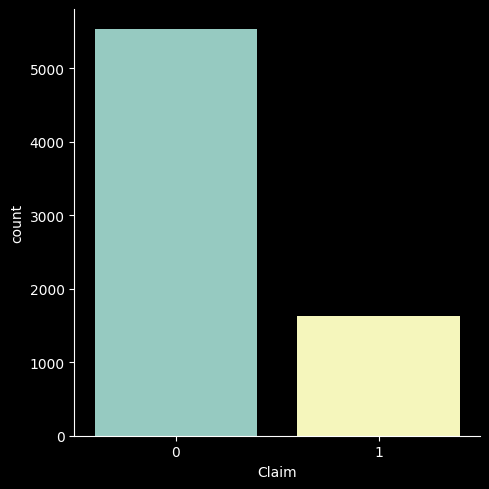

In [21]:
# explorons la distribution de la target
sns.catplot(data=train, x=target, kind='count')
plt.show()

### Compréhension des variables

In [5]:
variable_description

,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


Matrice de corrélation entre les variables

<Axes: title={'center': 'Corrélation des features'}>

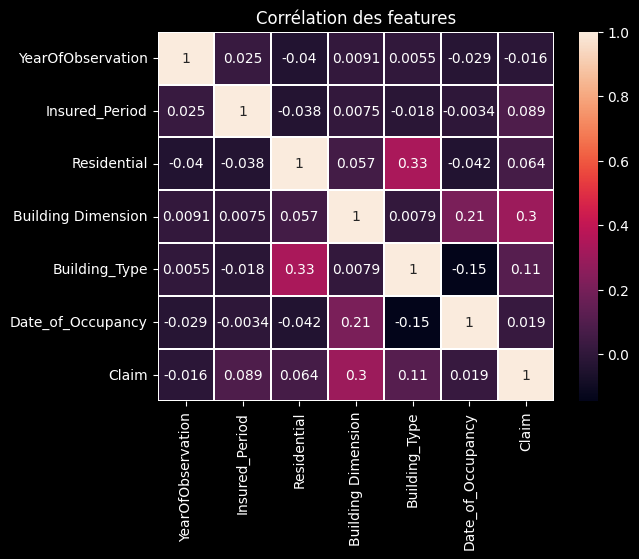

In [15]:
plt.title('Corrélation des features')
sns.heatmap(train.corr(numeric_only=True), linewidths=0.05, annot=True)

> 00 corrélation entre les variables du dataset

## Preprocessing

In [46]:
def preprocessing_data_1(data: pd.DataFrame, scaler) -> pd.DataFrame:
    ''' arrange un dataset
    '''
    # copie du dataset
    data1 = data.copy()
    # arrangement de la colonne du nombre de fenêtres
    data1['NumberOfWindows'] = data1['NumberOfWindows'].map(
        {'   .': 0, '>=10': 10}).fillna(data1['NumberOfWindows'])
    data1['NumberOfWindows'] = data1['NumberOfWindows'].astype(int)
    # suppression de la variable d'identifiants uniques
    data1.drop(users_id, axis=1, inplace=True)
    # la liste des colonnes discrètes
    object_columns = list(data1.select_dtypes(include='object').columns)
    # encodage des variables discrètes
    encoder = OrdinalEncoder()
    data1[object_columns] = encoder.fit_transform(data1[object_columns])
    # normalisation
    data1[data1.columns] = scaler.fit_transform(data1)
    return data1


def preprocessing_data_2(data: pd.DataFrame, scaler) -> pd.DataFrame:
    ''' Réalise la phase de pré-traitement d'un dataset à savoir l'encodage 
    des variables discrètes et la normalisation de toutes les variables 
    '''
    return data


Instantiating the scalers

In [47]:
# Instantiating the scalers
MMS = MinMaxScaler()
MAS = MaxAbsScaler()
SS = StandardScaler()
RS = RobustScaler()

In [49]:
scaler = MMS
train_pp = preprocessing_data_1(train, scaler)
test_pp = preprocessing_data_1(test, scaler)
train_pp.head(3)

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,0.25,1.0,0.0,0.0,1.0,1.0,1.0,0.013802,0.0,0.881104,0.0,0.00536,0.0
1,0.75,1.0,0.0,1.0,0.0,0.0,0.0,0.023354,0.0,0.647558,0.4,0.00536,0.0
2,0.50,1.0,0.0,0.0,1.0,1.0,1.0,0.028368,0.0,0.881104,0.0,0.00536,0.0


## Modelling

### Splitting

In [50]:
X_train_pp = train_pp.drop([target], axis=1)
y_train_pp = train_pp[target]
X_train_pp.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,0.25,1.0,0.0,0.0,1.0,1.0,1.0,0.013802,0.0,0.881104,0.0,0.00536
1,0.75,1.0,0.0,1.0,0.0,0.0,0.0,0.023354,0.0,0.647558,0.4,0.00536
2,0.50,1.0,0.0,0.0,1.0,1.0,1.0,0.028368,0.0,0.881104,0.0,0.00536
3,0.25,1.0,0.0,1.0,1.0,1.0,1.0,0.135584,0.0,0.881104,0.0,0.00536
4,0.50,1.0,0.0,1.0,0.0,0.0,0.0,0.032428,0.0,0.541401,0.3,0.00536


In [51]:
X_Train, X_Val, y_Train, y_Val = train_test_split(X_train_pp, y_train_pp, test_size = 0.1, random_state=SEED)

### Entrainement du modèle avec CatBoost

In [52]:
params = {
    'n_estimators': 3000,
    'learning_rate': 0.1,
    'objective': 'Logloss',
    'rsm': 0.7,
    'random_seed': SEED,
    'early_stopping_rounds': 200,
    'use_best_model': True,
}

In [53]:
model_cb = CatBoostClassifier(**params)
model_cb.fit(X_Train, y_Train, eval_set=[(X_Val, y_Val)], verbose=50)

y_model_cb = model_cb.predict(X_Val)
metrique = 1 - accuracy_score(y_Val, y_model_cb)
print(f"Taux d'erreur du {str(model_cb)} : {metrique}")

0:	learn: 0.6525171	test: 0.6499065	best: 0.6499065 (0)	total: 209ms	remaining: 10m 27s
50:	learn: 0.4572586	test: 0.4485607	best: 0.4485607 (50)	total: 875ms	remaining: 50.6s
100:	learn: 0.4349066	test: 0.4501763	best: 0.4474635 (70)	total: 1.36s	remaining: 39.1s
150:	learn: 0.4113206	test: 0.4551351	best: 0.4474635 (70)	total: 1.74s	remaining: 32.9s
200:	learn: 0.3900822	test: 0.4580301	best: 0.4474635 (70)	total: 2.3s	remaining: 32s
250:	learn: 0.3740065	test: 0.4611796	best: 0.4474635 (70)	total: 2.68s	remaining: 29.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4474635189
bestIteration = 70

Shrink model to first 71 iterations.
Taux d'erreur du <catboost.core.CatBoostClassifier object at 0x000001D0784A14B0> : 0.19692737430167595


Algorithme de recherche du meilleur SEED

In [ ]:
def best_seed_search(model):
	''' recherche le meilleur seed
	'''
	scores_models = []
	for i in range(51):
		X_Train, X_Val, y_Train, y_Val = train_test_split(X_train_pp, y_train_pp, stratify = y_train_pp, test_size = 0.1, random_state=i)
		model.fit(X_Train, y_Train)
		y_model = model.predict(X_Val)
		metrique = 1 - accuracy_score(y_Val, y_model)
		scores_models.append(metrique)
		print(i, ' - ', metrique)

best_seed_search(model)

Nouveau seed après recherche du meilleur

In [ ]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

Matrice de confusion

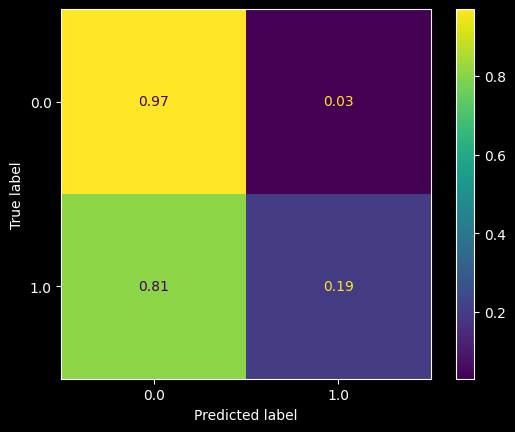

In [54]:
# traçons la matrice de confusion pour le modèle
ConfusionMatrixDisplay.from_estimator(model_cb, X_Val, y_Val, normalize='true')
plt.show()

## Prediction

In [55]:
model = model_cb

In [56]:
test[target] = model.predict(test_pp)
test.head(5)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310,0.0
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310,0.0
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310,0.0
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321,0.0
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321,0.0


## Submission

Visualisation du fichier d'exemple de soumission

In [31]:
sample_submission.head()

,Customer Id,Claim
0,H0,1
1,H10000,1
2,H10001,1
3,H10002,1
4,H10003,1


Création de notre fichier de soumission

In [58]:
submissions = pd.DataFrame({users_id: test[users_id], target: test[target].astype(int)})
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
submissions.to_csv(f'submissions/submission_{today}.csv', index=False)

In [59]:
submissions

,Customer Id,Claim
0,H11920,0
1,H11921,0
2,H9805,0
3,H7493,0
4,H7494,0
...,...,...
3064,H11583,0
3065,H11720,0
3066,H11721,0
3067,H12408,0


## Model saving

In [61]:
# Save the model as a pickle in a file
file_name = 'basique_0.553050188'
joblib.dump(model, f'models/{file_name}.pkl')

['models/basique_0.553050188.pkl']